In [3]:
import os
# os.chdir(os.path.dirname(os.path.abspath(__file__))) # change to current file path
import random
import time, shutil
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from hparam import Hparam
from data_load import SpeakerDatasetPreprocessed
from speech_embedder_net import SpeechEmbedder, SpeechEmbedder_Softmax, GE2ELoss_, AngularPenaltySMLoss, AAMSoftmax,SubcenterArcMarginProduct, get_centroids, get_cossim
from torch.utils.tensorboard import SummaryWriter
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import numpy as np
from numpy.linalg import solve
import scipy.linalg
import scipy.stats
from tqdm import tqdm
from utils import compute_eer, fit_bmm
import pandas as pd
from sklearn.mixture import GaussianMixture

random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
hp = Hparam(file='config/config.yaml')
print(hp.stage, hp.nld.noise_type)
def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])

    return params

nld


In [4]:
def extract_emb(embedder_net, batch):
    if batch.ndim == 4:
        batch = batch.reshape(-1, batch.size(2), batch.size(3))
    if embedder_net.__class__.__name__ == 'SpeechEmbedder_Softmax':
        embeddings = embedder_net.get_embedding(batch)
    else:
        embeddings = embedder_net(batch)
    return embeddings

def get_criterion(device, model_path):
    loss_type = None
    for i in ['/Softmax/', '/GE2E/', '/AAM/', '/AAMSC/']:
        if i in model_path:
            if i == '/Softmax/':
                loss_type = 'Softmax'
            elif i == '/GE2E/':
                loss_type = 'GE2E'
            elif i == '/AAM/':
                loss_type = 'AAM'
            else:
                loss_type = 'AAMSC'
            break
    if loss_type == 'Softmax':
        criterion = torch.nn.NLLLoss()
    elif loss_type == 'GE2E':
        criterion = GE2ELoss_(init_w=10.0, init_b=-5.0, loss_method='softmax').to(device)
    elif loss_type == 'AAM':
        criterion = AAMSoftmax(hp.model.proj, 5994, scale=hp.train.s, margin=hp.train.m, easy_margin=True).to(device)
    elif loss_type == 'AAMSC':
        criterion = SubcenterArcMarginProduct(hp.model.proj, 5994, s=hp.train.s, m=hp.train.m, K=hp.train.K).to(device)
    else:
        raise ValueError('Unknown loss')
    return criterion, loss_type

model_path = hp.nld.model_path

device = torch.device(hp.device)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

try:
    embedder_net = SpeechEmbedder(hp).to(device)
    embedder_net.load_state_dict(torch.load(model_path))
except:
    embedder_net = SpeechEmbedder_Softmax(hp=hp, num_classes=5994).to(device)
    embedder_net.load_state_dict(torch.load(model_path))

criterion = get_criterion(hp.device, model_path)[0]
criterion.load_state_dict(torch.load(model_path.replace('ckpt_epoch', 'ckpt_criterion_epoch')))
embedder_net.eval()
criterion.eval()

print("Number of params: ", get_n_params(embedder_net))

Initialised GE2E
Number of params:  12134656


# Distance Ranking

## $\mathbf{c}_{s}=\frac{1}{\sum_{u} 1} \sum_{u} \mathbf{f}_{s, u}$
## $\mathbf{d(f_{s, u}, c_s)} = 1 - \dfrac{\mathbf{f}_{s, u} \cdot \mathbf{c}_s}{\Vert \mathbf{f}_{s, u} \Vert _2 \cdot \Vert \mathbf{c}_s \Vert _2}$

In [5]:
ypreds = []
ylabels = []


cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
nld_dataset = SpeakerDatasetPreprocessed(hp)
nld_loader = DataLoader(nld_dataset, batch_size=hp.nld.N, shuffle=False, num_workers=hp.nld.num_workers, drop_last=False)
for batch_id, (mel_db_batch, labels, is_noisy, utterance_ids) in enumerate(tqdm(nld_loader)):
    utterance_ids = np.array(utterance_ids).T
    mel_db_batch = mel_db_batch.to(device)
    
    embeddings = extract_emb(embedder_net, mel_db_batch) 
    embeddings = torch.reshape(embeddings, (hp.nld.N, hp.nld.M, embeddings.size(1))) # (1, M, 256)
    centroid = embeddings.mean(dim=1, keepdim=True)
    embeddings = embeddings / embeddings.norm(dim=2, keepdim=True) 
    centroid = centroid / centroid.norm(dim=2, keepdim=True)
    cos_sim = get_cossim(embeddings, centroid, cos)
    ypreds.extend((1 - cos_sim).reshape(-1).cpu().detach().numpy().tolist())
    ylabels.extend(is_noisy.reshape(-1).cpu().detach().numpy().tolist())
    if batch_id == 500:
        break
    



Loading spkr2utter and spkr2utter_mislabel...


  8%|▊         | 500/5994 [01:38<17:58,  5.09it/s]


In [6]:
# select top noise level % from ypreds
noise_level = hp.nld.noise_level
print("noise level: ", hp.nld.noise_level)
ypreds = np.array(ypreds)
ylabels = np.array(ylabels)

def compute_precision(ypreds, ylabels, noise_level):
    selected = np.argsort(ypreds)[-int(len(ypreds) * noise_level / 100):]
    selected_ypreds = ypreds[selected]
    selected_ylabels = ylabels[selected]
    # compute precision
    return selected_ylabels.sum() / len(selected_ylabels)

print("top noise level precision: ", compute_precision(ypreds, ylabels, noise_level))

noise level:  20
top noise level precision:  0.9371253496736379


plot distance distribution


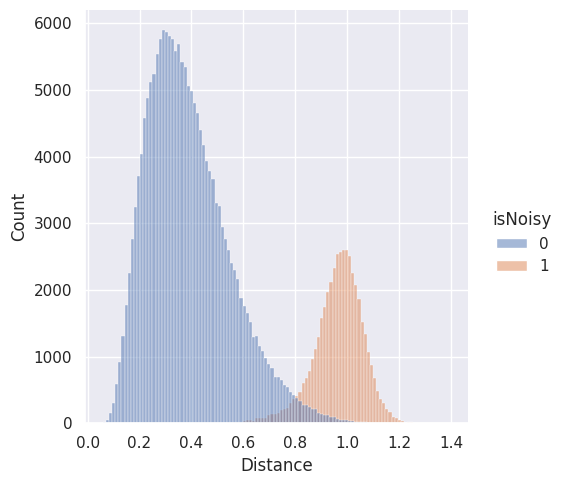

In [16]:
# create df from ypreds and ylabels
df = pd.DataFrame({"Distance": ypreds, "isNoisy": ylabels})
print("plot distance distribution")
import seaborn as sns
sns.set()
# ax = sns.displot(ypreds)
p = sns.displot(df, x="Distance", hue="isNoisy")
p.fig.set_dpi(100)

## predict with BMM

Estimated noise level:  0.20205062873526358
Noise level:  19.943253971777953
top estimated noise level precision:  0.989010989010989
top noise level precision:  0.9371253496736379


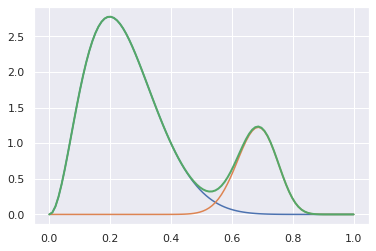

In [9]:
bmm_model, bmm_model_max, bmm_model_min = fit_bmm(ypreds, max_iters=50)
bmm_model.plot()

# Noise level estimation
if hp.nld.noise_level >=70:
    estimated_noise_level = bmm_model.weight[0]
else:
    estimated_noise_level = bmm_model.weight[1]
print("Estimated noise level: ", estimated_noise_level)
print("Noise level: ", ylabels.sum() / len(ylabels) * 100)
print("top estimated noise level precision: ", compute_precision(ypreds, ylabels, estimated_noise_level))
print("top noise level precision: ", compute_precision(ypreds, ylabels, hp.nld.noise_level))

In [10]:
ypreds_bmm = bmm_model.predict(ypreds)
if hp.nld.noise_level >=70:
    ypreds_bmm = 1 - ypreds_bmm
bmm_precision = (ypreds_bmm * ylabels).sum() / ypreds_bmm.sum()
print("BMM precision: ", bmm_precision)

BMM precision:  0.4364222654790696


## Predict with GMM

In [11]:
gmm_model = GaussianMixture(n_components=2, random_state=1)
gmm_model.fit(ypreds.reshape(-1, 1))


# Noise level estimation
ypreds_gmm = gmm_model.predict(ypreds.reshape(-1, 1))
if gmm_model.means_[0][0] > gmm_model.means_[1][0]:
    ypreds_gmm = 1 - ypreds_gmm
estimated_noise_level = ypreds_gmm.sum() / len(ypreds) * 100
print("Estimated noise level: ", estimated_noise_level)
print("Noise level: ", ylabels.sum() / len(ylabels) * 100)
print("top estimated noise level precision: ", compute_precision(ypreds, ylabels, estimated_noise_level))

Estimated noise level:  24.228067526885543
Noise level:  0.0
top estimated noise level precision:  0.0


In [12]:
gmm_precision = (ypreds_gmm * ylabels).sum() / ypreds_gmm.sum()
print("GMM precision: ", gmm_precision)

GMM precision:  0.0


# Loss Ranking

# Confidence Ranking

## $\mathbf{I}_u = max(  (1 - y) \textbf{CLS}(u; \theta))$

In [ ]:
ypreds = []
ylabels = []


cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
nld_dataset = SpeakerDatasetPreprocessed(hp)
nld_loader = DataLoader(nld_dataset, batch_size=hp.nld.N, shuffle=False, num_workers=hp.nld.num_workers, drop_last=False)
for batch_id, (mel_db_batch, labels, is_noisy, utterance_ids) in enumerate(tqdm(nld_loader)):
    utterance_ids = np.array(utterance_ids).T
    mel_db_batch = mel_db_batch.to(device)
    
    embeddings = extract_emb(embedder_net, mel_db_batch) 
    embeddings = torch.reshape(embeddings, (hp.nld.N, hp.nld.M, embeddings.size(1))) # (1, M, 256)
    centroid = embeddings.mean(dim=1, keepdim=True)
    embeddings = embeddings / embeddings.norm(dim=2, keepdim=True) 
    centroid = centroid / centroid.norm(dim=2, keepdim=True)
    cos_sim = get_cossim(embeddings, centroid, cos)
    ypreds.extend((1 - cos_sim).reshape(-1).cpu().detach().numpy().tolist())
    ylabels.extend(is_noisy.reshape(-1).cpu().detach().numpy().tolist())
    if batch_id == 500:
        break
    



# Plot PR curve and ROC curve

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure("P-R Curve")
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
precision, recall, thresholds = precision_recall_curve(ylabels, ypreds)
plt.plot(recall,precision)
plt.show()

In [ ]:
# plot roc curve and compute auc
fpr, tpr, thresholds = roc_curve(ylabels, ypreds)
auc = scipy.integrate.trapz(tpr, fpr)
plt.figure("ROC Curve")
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr)
plt.show()
print("AUC: ", auc)